In [2]:
import cupy as np
import sys
import pdb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    x = x.astype('float')

    #normalize each example in x to have 0 mean and 1 std

    # Calculate the mean and standard deviation for each feature
    feature_means = np.mean(x, axis=0)
    feature_stds = np.std(x, axis=0)
    feature_stds = feature_stds + (feature_stds == 0)

    # Normalize each feature to have 0 mean and 1 std
    x = (x - feature_means) / (feature_stds)

    # Adjust labels to start from 0 if they start from 1
    y = y - 1

    return x, y

def get_metric(y_true, y_pred):
    '''
    Args:
        y_true: np array of [NUM_SAMPLES x r] (one hot)
                or np array of [NUM_SAMPLES]
        y_pred: np array of [NUM_SAMPLES x r] (one hot)
                or np array of [NUM_SAMPLES]

    '''
    results = classification_report(y_pred, y_true)
    print(results)

In [4]:
x_test, y_test = get_data('x_test.npy', 'y_test.npy')
x_train, y_train = get_data('x_train.npy', 'y_train.npy')

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000, 1024), (10000,), (1000, 1024), (1000,))

In [5]:
label_encoder = OneHotEncoder(sparse_output = False)
label_encoder.fit(np.expand_dims(y_train, axis = -1).get())

y_train_onehot = np.asarray(label_encoder.transform(np.expand_dims(y_train, axis = -1).get()))
y_test_onehot = np.asarray(label_encoder.transform(np.expand_dims(y_test, axis = -1).get()))

In [6]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.weights = []
        self.biases = []
        self.activations = []

        # Initialize weights and biases for each layer
        for i in range(len(layer_sizes) - 1):
            # Weights are initialized with small random values
            self.weights.append(np.random.randn(layer_sizes[i+1], layer_sizes[i]) * 0.01)
            self.biases.append(np.zeros((layer_sizes[i+1], 1)))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)


    def sigmoid(self, z):
        
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        
        e_z = np.exp(z)
        return e_z / e_z.sum(axis=0, keepdims=True)

    def feedforward(self, x):
        activation = x
        self.activations = [x]  
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, activation) + b
            activation = self.relu(z) if w is not self.weights[-1] else self.softmax(z)
            self.activations.append(activation)

        return self.activations[-1]

array([[0.20565902],
       [0.19788553],
       [0.19395291],
       [0.19847146],
       [0.20403108]])

In [7]:
class NeuralNetwork(NeuralNetwork):
    def cross_entropy_loss(self, y_pred, y_true):
        m = y_true.shape[1] 
        loss = -np.sum(y_true * np.log(y_pred)) / m
        return loss

    def backpropagation(self, y_true):
        m = y_true.shape[1]  # Number of examples
        y_pred = self.activations[-1]  # The output of the last layer
        y_true = y_true.reshape(y_pred.shape)

        d_weights = [np.zeros(w.shape) for w in self.weights]
        d_biases = [np.zeros(b.shape) for b in self.biases]

        # Calculate derivative of loss w.r.t. the last layer output
        d_loss = y_pred - y_true

        for i in reversed(range(len(d_weights))):
            d_activations = d_loss * self.relu_derivative(self.activations[i+1]) if i != len(d_weights) - 1 else d_loss
            d_weights[i] = np.dot(d_activations, self.activations[i].T) / m
            d_biases[i] = np.sum(d_activations, axis=1, keepdims=True) / m
            if i != 0:
                d_loss = np.dot(self.weights[i].T, d_activations)

        return d_weights, d_biases

    def sigmoid_derivative(self, s):
        return s * (1 - s)

    def update_parameters(self, d_weights, d_biases, learning_rate):
        """
        Updates the parameters using the computed gradients.
        """
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * d_weights[i]
            self.biases[i] -= learning_rate * d_biases[i]

    def train(self, x_train, y_train, epochs, mini_batch_size, learning_rate, conv_threshold = 0.001, conv_epochs = 5):
        n = x_train.shape[1]

        loss_history = []
        permutation = np.random.permutation(n)
        for epoch in range(epochs):
            x_train_shuffled = x_train[:, permutation]
            y_train_shuffled = y_train[:, permutation]

            for k in range(0, n, mini_batch_size):
                mini_batch_x = x_train_shuffled[:, k:k + mini_batch_size]
                mini_batch_y = y_train_shuffled[:, k:k + mini_batch_size]
                # Forward pass
                self.feedforward(mini_batch_x)
                # Backward pass
                d_weights, d_biases = self.backpropagation(mini_batch_y)
                # Update parameters
                self.update_parameters(d_weights, d_biases, learning_rate)

            loss = self.cross_entropy_loss(self.feedforward(x_train), y_train)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

            loss_history.append(loss)

            if len(loss_history) > conv_epochs:
                temp = loss_history[-conv_epochs:]
                if np.std(temp) < conv_threshold:
                    print('Converged')
                    break

In [12]:
class NeuralNetwork(NeuralNetwork):
    def train_c(self, x_train, y_train, epochs, mini_batch_size, learning_rate, conv_threshold = 0.001, conv_epochs = 5):
        n = x_train.shape[1]  
        loss_history = []
        permutation = np.random.permutation(n)
        learning_rate_c = learning_rate
        for epoch in range(epochs):
            learning_rate = learning_rate_c / pow(epoch+1, 0.5)
            x_train_shuffled = x_train[:, permutation]
            y_train_shuffled = y_train[:, permutation]

            for k in range(0, n, mini_batch_size):
                mini_batch_x = x_train_shuffled[:, k:k + mini_batch_size]
                mini_batch_y = y_train_shuffled[:, k:k + mini_batch_size]
                # Forward pass
                self.feedforward(mini_batch_x)
                # Backward pass
                d_weights, d_biases = self.backpropagation(mini_batch_y)
                # Update parameters
                self.update_parameters(d_weights, d_biases, learning_rate)

            loss = self.cross_entropy_loss(self.feedforward(x_train), y_train)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

            loss_history.append(float(loss))

            if len(loss_history) > conv_epochs:
                temp = loss_history[-conv_epochs:]
                if statistics.stdev(temp) < conv_threshold:
                    print('Converged')
                    break

In [13]:
import statistics
y_train_one_hot = np.eye(5)[y_train].T

hidden_layers = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]]
layers = [[1024] + hidden_layer + [5] for hidden_layer in hidden_layers]
models_e = {}
for layer in layers:
    print(f'layer: {layer}')
    nn = NeuralNetwork(layer)
    nn.train_c(x_train.T, y_train_one_hot, epochs=200, mini_batch_size=32, learning_rate=0.01)
    models_e[str(layer)] = nn

layer: [1024, 512, 5]
Epoch 1/200, Loss: 0.8422
Epoch 2/200, Loss: 0.6864
Epoch 3/200, Loss: 0.6038
Epoch 4/200, Loss: 0.5513
Epoch 5/200, Loss: 0.5141
Epoch 6/200, Loss: 0.4857
Epoch 7/200, Loss: 0.4631
Epoch 8/200, Loss: 0.4445
Epoch 9/200, Loss: 0.4289
Epoch 10/200, Loss: 0.4154
Epoch 11/200, Loss: 0.4037
Epoch 12/200, Loss: 0.3933
Epoch 13/200, Loss: 0.3840
Epoch 14/200, Loss: 0.3756
Epoch 15/200, Loss: 0.3679
Epoch 16/200, Loss: 0.3608
Epoch 17/200, Loss: 0.3543
Epoch 18/200, Loss: 0.3482
Epoch 19/200, Loss: 0.3426
Epoch 20/200, Loss: 0.3373
Epoch 21/200, Loss: 0.3323
Epoch 22/200, Loss: 0.3276
Epoch 23/200, Loss: 0.3231
Epoch 24/200, Loss: 0.3189
Epoch 25/200, Loss: 0.3148
Epoch 26/200, Loss: 0.3110
Epoch 27/200, Loss: 0.3073
Epoch 28/200, Loss: 0.3037
Epoch 29/200, Loss: 0.3003
Epoch 30/200, Loss: 0.2970
Epoch 31/200, Loss: 0.2939
Epoch 32/200, Loss: 0.2908
Epoch 33/200, Loss: 0.2879
Epoch 34/200, Loss: 0.2850
Epoch 35/200, Loss: 0.2822
Epoch 36/200, Loss: 0.2796
Epoch 37/200, L

In [17]:
for layer in layers[-2:]:
    print(f'layer: {layer}')
    nn = NeuralNetwork(layer)
    nn.train_c(x_train.T, y_train_one_hot, epochs=100, mini_batch_size=32, learning_rate=0.01, conv_threshold=1e-5, conv_epochs=10)
    models_e[str(layer)] = nn

layer: [1024, 512, 256, 128, 5]
Epoch 1/200, Loss: 1.6090
Epoch 2/200, Loss: 1.6088
Epoch 3/200, Loss: 1.6086
Epoch 4/200, Loss: 1.6083
Epoch 5/200, Loss: 1.6080
Epoch 6/200, Loss: 1.6076
Epoch 7/200, Loss: 1.6071
Epoch 8/200, Loss: 1.6063
Epoch 9/200, Loss: 1.6053
Epoch 10/200, Loss: 1.6037
Epoch 11/200, Loss: 1.6014
Epoch 12/200, Loss: 1.5977
Epoch 13/200, Loss: 1.5916
Epoch 14/200, Loss: 1.5806
Epoch 15/200, Loss: 1.5587
Epoch 16/200, Loss: 1.5107
Epoch 17/200, Loss: 1.4132
Epoch 18/200, Loss: 1.2985
Epoch 19/200, Loss: 1.1810
Epoch 20/200, Loss: 1.0713
Epoch 21/200, Loss: 1.0064
Epoch 22/200, Loss: 0.9630
Epoch 23/200, Loss: 0.9296
Epoch 24/200, Loss: 0.9007
Epoch 25/200, Loss: 0.8737
Epoch 26/200, Loss: 0.8471
Epoch 27/200, Loss: 0.8217
Epoch 28/200, Loss: 0.7969
Epoch 29/200, Loss: 0.7728
Epoch 30/200, Loss: 0.7490
Epoch 31/200, Loss: 0.7254
Epoch 32/200, Loss: 0.7018
Epoch 33/200, Loss: 0.6779
Epoch 34/200, Loss: 0.6539
Epoch 35/200, Loss: 0.6295
Epoch 36/200, Loss: 0.6049
Epoch

In [25]:
layer = layers[-1]
print(f'layer: {layer}')
nn = NeuralNetwork(layer)
nn.train_c(x_train.T, y_train_one_hot, epochs=30, mini_batch_size=32, learning_rate=0.1, conv_threshold=1e-5, conv_epochs=20)
models_e[str(layer)] = nn

layer: [1024, 512, 256, 128, 64, 5]
Epoch 1/30, Loss: 1.6096
Epoch 2/30, Loss: 1.6094
Epoch 3/30, Loss: 1.6093
Epoch 4/30, Loss: 1.6092
Epoch 5/30, Loss: 1.6092
Epoch 6/30, Loss: 1.6091
Epoch 7/30, Loss: 1.6090
Epoch 8/30, Loss: 1.6088
Epoch 9/30, Loss: 1.6083
Epoch 10/30, Loss: 1.6059
Epoch 11/30, Loss: 1.5126
Epoch 12/30, Loss: 0.9601
Epoch 13/30, Loss: 0.5486
Epoch 14/30, Loss: 0.3521
Epoch 15/30, Loss: 0.2735
Epoch 16/30, Loss: 0.2092
Epoch 17/30, Loss: 0.1991
Epoch 18/30, Loss: 0.1548
Epoch 19/30, Loss: 0.1741
Epoch 20/30, Loss: 0.1891
Epoch 21/30, Loss: 0.1574
Epoch 22/30, Loss: 0.4083
Epoch 23/30, Loss: 0.0450
Epoch 24/30, Loss: 0.0308
Epoch 25/30, Loss: 0.0440
Epoch 26/30, Loss: 0.0559
Epoch 27/30, Loss: 0.0704
Epoch 28/30, Loss: 0.0291
Epoch 29/30, Loss: 0.0135
Epoch 30/30, Loss: 0.0159


In [ ]:
# save models
import pickle

with open('pickles/models_e.pickle', 'wb') as handle:
    pickle.dump(models_e, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
# report results
for layer in layers:
    nn = models_e[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred.get(), y_train.get())
    print(f"{layer} hidden layer size")
    print('Training')
    print(results)

    results = classification_report(y_test_pred.get(), y_test.get())
    print('Test')
    print(results)

[1024, 512, 5] hidden layer size
Training
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1980
           1       0.97      0.97      0.97      1984
           2       0.94      0.95      0.95      1924
           3       0.94      0.94      0.94      2025
           4       0.97      0.97      0.97      2087

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Test
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       224
           1       0.87      0.93      0.90       187
           2       0.79      0.83      0.81       190
           3       0.73      0.72      0.72       189
           4       0.90      0.80      0.85       210

    accuracy                           0.86      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.86      0

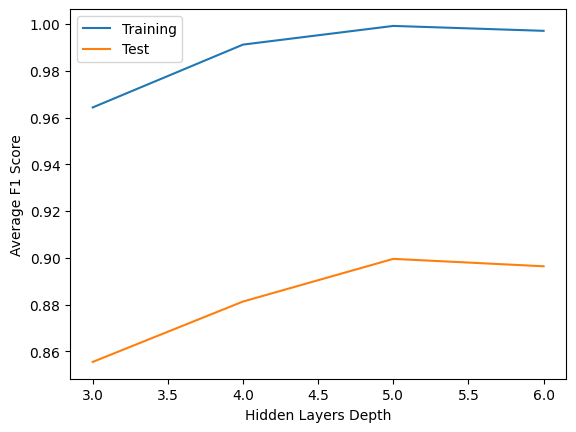

In [28]:
avg_f1_scores_training = []
avg_f1_scores_test = []
for layer in layers:
    nn = models_e[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred.get(), y_train.get(), output_dict=True)
    avg_f1_scores_training.append(results['weighted avg']['f1-score'])

    results = classification_report(y_test_pred.get(), y_test.get(), output_dict=True)
    avg_f1_scores_test.append(results['weighted avg']['f1-score'])

plt.plot([len(layer) for layer in layers], avg_f1_scores_training, label = 'Training')
plt.plot([len(layer) for layer in layers], avg_f1_scores_test, label = 'Test')
plt.xlabel('Hidden Layers Depth')
plt.ylabel('Average F1 Score')
plt.legend()
plt.savefig('(e) relu adaptive training f1 vs hidden_depth.png')
plt.show()